Iteration:  0
Total windows: 385
Total windows: 350
Iteration:  1
Total windows: 385
Total windows: 350
Iteration:  2
Total windows: 385
Total windows: 350
Iteration:  3
Total windows: 385
Total windows: 350
Iteration:  4
Total windows: 385
Total windows: 350


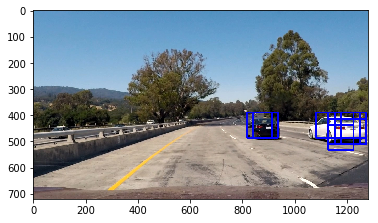

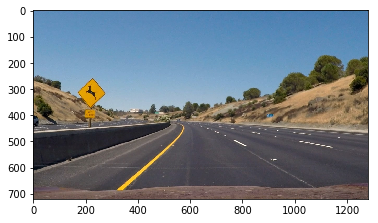

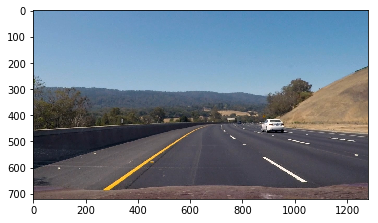

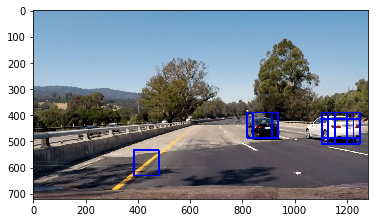

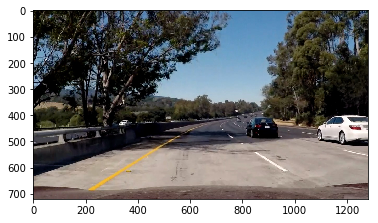

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle_Y.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]
cspace = dist_pickle["colorspace"]
hog_channel = dist_pickle["hog_channel"]

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block): # spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = int(2)  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, tsqrt=True)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, tsqrt=True)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, tsqrt=True)
    
    bboxes_out = list()
    counter=0
    print("Total windows:", nxsteps*nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == "ALL":
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            elif hog_channel == 2:
                hog_features = hog_feat3
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)
        
#             print("Feature range: ", np.min(spatial_features), np.max(spatial_features), np.mean(spatial_features))
#             print("Feature range: ", np.min(hist_features), np.max(hist_features), np.mean(hist_features))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1)) 
            test_prediction = svc.decision_function(test_features)
#             print(test_prediction)
            if test_prediction[0] > 0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes_out.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            
    return draw_img, bboxes_out
    
ystart = 400 
ystop = [528 , 656]
scale = [1.0, 1.5]

bbox_lists = []
images = []
for i in range(5):
    img = mpimg.imread('test_images/test%d.jpg' % (i+1))
    images.append(img)
    out_img = np.copy(img)
    bboxes_out = list()
    print("Iteration: ", i)
    for j in range(len(scale)):
        out_img, bboxes = find_cars(img, ystart, ystop[j], scale[j], svc, X_scaler, orient, pix_per_cell, cell_per_block) #, spatial_size, hist_bins)
        bboxes_out += bboxes
    bbox_lists.append(bboxes_out)
    plt.figure()
    plt.imshow(out_img)

In [4]:
import pickle

pickle.dump(bboxes_out, open('bbox_pickle.p', 'wb'))

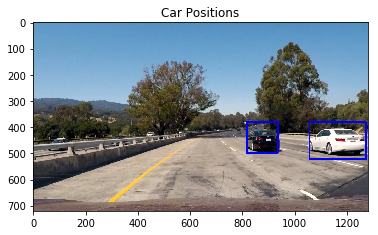

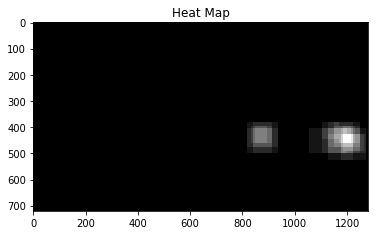

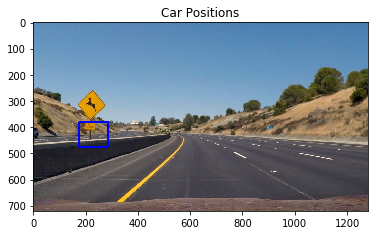

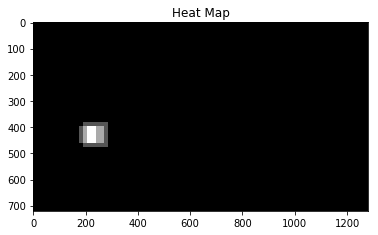

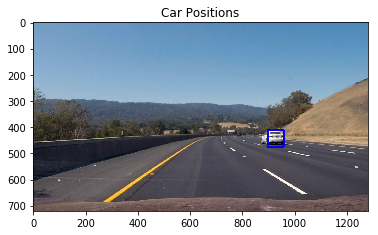

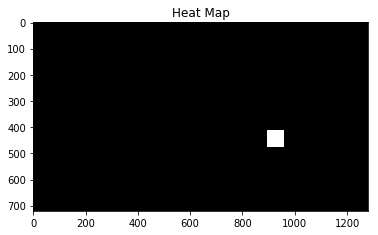

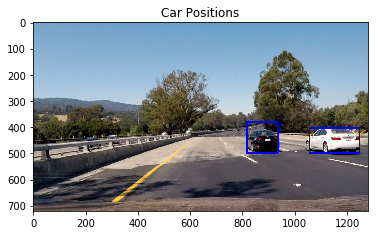

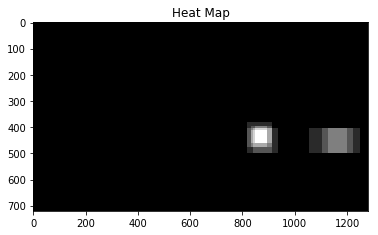

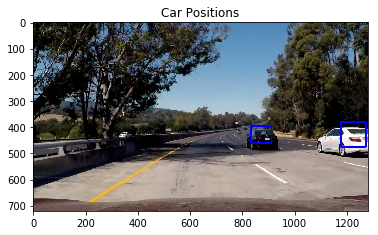

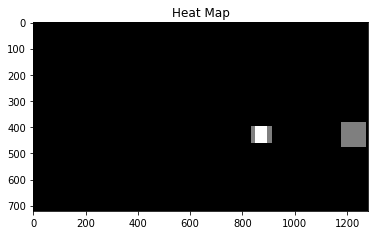

In [10]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold, labels):
    for car_number in range(1, labels[1]+1):
        region = labels[0] == car_number
        # Find pixels with each car_number label value
        mval = np.max(heatmap[region])
        if mval < threshold:
            nonzero = (region).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Zero out pixels below the threshold
            heatmap[nonzero] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


for i in range(5):
    image = images[i]
    heat = np.zeros_like(image).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_lists[i])
    initial_labels = label(heat)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1, initial_labels) 

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255) / np.max(heat)
    labels = label(heatmap)
    
    # Find final boxes from heatmap using label function
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.figure()
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
